In [175]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import math

abspath = os.getcwd()
i = ["A","labels-A","B","labels-B","usps","labels-usps","irlstest","irlsw","labels-irlstest"]
csv_dict = {}
for j in range(len(i)):
    relative = '\\pp3data\\'+i[j]+'.csv'
    fullpath = abspath+relative
    with open(fullpath) as csv_file:
        filer = csv.reader(csv_file,quoting=csv.QUOTE_NONNUMERIC)
        csv_dict[i[j]] = [line for line in filer]

#generative model
def gen_mod_trn(trn_d,trn_l):
    #determining mu1 and mu2 of two classification using formula mk = (1/nk)*sum(tk*xk) and (ml = 1/nl)*sum((1-tl)*xl)
    mu_1 = 0
    mu_2 = 0
    n1 = np.count_nonzero(trn_l == 1)
    n2 = np.count_nonzero(trn_l == 0)
    
    for i in range(len(trn_d)):
        prod = np.dot(trn_l[i][0],trn_d[i])
        mu_1 = mu_1+prod
    mu_1 = mu_1/n1
    
    for i in range(len(trn_d)):
        prod = np.dot((1-trn_l[i][0]),trn_d[i])
        mu_2 = mu_2+prod
    mu_2 = mu_2/n2
    #determining the sigma using the (n1/n*s1)+(n2/n*s2) formula
    S2 = 0
    S1 = 0
    for i in range(len(trn_d)):
        if trn_l[i] == 0:
            s2_1 = trn_d[i]-mu_2
            s2_2 = s2_1.transpose()
            s2 = np.dot(s2_1,s2_2)
            S2 = s2+S2
        else:
            s1_1 = trn_d[i]-mu_1
            s1_2 = s1_1.transpose()
            s1 = np.dot(s1_1,s1_2)
            S1 = s1+S1
    S2 = S2/n2
    S1 = S1/n1
    sigma = ((n1/(len(trn_l)))*S1)+((n2/(len(trn_l)))*S2)
    
    p_c1 = n1/len(trn_l)
    p_c2 = n2/len(trn_l)
    
    mu1_tr = mu_1.transpose()
    mu2_tr = mu_2.transpose()
    #determing the weight and w0 values
    w0_1 = np.dot(mu1_tr,1/sigma)
    w0_1 = np.dot(w0_1,mu_1)
    w0_1 = (-1/2)*w0_1
    w0_2 = np.dot(mu2_tr,1/sigma)
    w0_2 = np.dot(w0_2,mu_2)
    w0_2 = (1/2)*w0_2
    w0_3 = np.log((p_c1/p_c2))
    w0 = w0_1+w0_2+w0_3
    
    w = mu_1-mu_2
    w = np.dot(1/sigma,w)
    #returning the weights
    return (w,w0)

def gen_mod(train_d,train_l,test_d,test_l):
    wg,wg0 = gen_mod_trn(train_d,train_l)
    err = 0
    crt = 0
    #based on computed weights test data is evaluated for calcuating the error rate
    for i in range(len(test_d)):
        x = test_d[i]
        x=x.transpose()
        a = np.dot(wg,x)
        a = a+wg0
        sig_a = 1/(1+np.exp(-a))
        if (sig_a >= (1/2)):
            pred_l = 1
        else:
            pred_l = 0
        if pred_l == test_l[i]:
            crt = crt+1
        else:
            err = err+1
    er_rt = err/len(test_l)
    return (er_rt)

def wmap_det(data,label):
    d_t = data.transpose()
    wn = np.zeros(len(d_t))
    iden = np.identity(len(d_t))
    a_id = np.dot(alpha,iden)
    wn1 = wn
    n=0
    #initialising the wn as zero vector
    wn1 = np.expand_dims(wn1, axis=1)
    wn = np.expand_dims(wn, axis=1)
    while (True):
        num = np.linalg.norm((wn1-wn),ord = 2)
        den = np.linalg.norm(wn,ord=2)
        chk = num/den
        #checking whether the normalized condition or the no of steps as explained in question is met as stopping criteria
        if (((chk < (10**-3)) | n>=100)):
            break
        #assigning the previous cycle wn1 as this cycle wn to again iterate for wn1
        wn = wn1
        y = np.array(np.zeros(len(data)))
        yi_r = np.array(np.zeros(len(data)))
        n += 1
        for i in range (len(data)):
            ai = np.dot(data[i],wn)
            yi = 1/(1+(np.exp(-ai)))
            y[i] = yi
            yi_r[i] = yi*(1-yi)     
        r = np.diag(yi_r)
        wn1_1 = np.dot(d_t,r)
        wn1_1 = np.dot(wn1_1,data)
        wn1_1 = a_id+wn1_1
        wn1_1 = np.linalg.inv(wn1_1)
        y = np.expand_dims(y, axis=1)
        wn1_2 = y-label
        wn1_2 = np.dot(d_t,wn1_2)
        wn1_2_2 = np.dot(alpha,wn)
        wn1_2 = wn1_2+wn1_2_2
        wn1 = np.dot(wn1_1,wn1_2)
        wn1 = wn-wn1
    return(wn1)

#computing the w and sn values based on the training data and label
def bay_mod_trn(trn_d,trn_l):
    wmap = wmap_det(trn_d,trn_l)
    y = np.array(np.zeros(len(trn_d)))
    trn_dt = trn_d.transpose()
    sn_2 = 0 
    iden = np.identity(len(trn_dt))
    sn_1 = np.dot(1/alpha,iden)
    for i in range (len(trn_d)):
        ai = np.dot(trn_d[i],wmap)
        yi = 1/(1+(np.exp(-ai)))
        y[i] = yi
        val_1 = yi*(1-yi)
        tr = trn_d[i].transpose()
        val_2 = np.dot(trn_d[i],tr)
        val = val_1*val_2
        sn_2 = sn_2 + val
    sn = sn_1+sn_2
    return (wmap,sn)

#computing the weights and sn based on training data and evaluating the error rate by using that weights and sn on test data
def bay_mod(tr_d,tr_l,te_d,te_l):
    tr_d = np.insert(tr_d,0,1,axis = 1)
    te_d = np.insert(te_d,0,1,axis = 1)
    wn,sn = bay_mod_trn(tr_d,tr_l)
    wn_t = wn.transpose()
    err = 0
    crt = 0
    for i in range(len(te_d)):
        mu_a = np.dot(te_d[i],wn)
        sigma_sq_a = np.dot(te_d[i],sn)
        te_tr = te_d[i].transpose()
        sigma_sq_a = np.dot(sigma_sq_a,te_tr)
        k_si_sq_a = ((1+((np.pi*sigma_sq_a)/8))**(-1/2))
        sigma = k_si_sq_a*mu_a
        pr_ci = 1/(1+(np.exp(-sigma)))
        if (pr_ci >= (1/2)):
            pred_l = 1
        else:
            pred_l = 0
        if pred_l == te_l[i]:
            crt = crt+1
        else:
            err = err+1
    er_rt = err/len(te_l)
    return (er_rt)

#spliting the total data into 2/3 for training and rest for testing and returnign the er rate of generative and bayesian(discriminative model)
def main_fn(data,label):
    data = np.array(data)
    label = np.array(label)
    train_set = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    N = len(data)
    tr = int((2/3)*len(data))
    tst = N-tr
    tr_idx = np.random.choice(np.arange(len(data)), tr, replace=False)
    tr_d = data[tr_idx]
    tr_l = label[tr_idx]
    tst_idx = np.array(np.zeros(tst))
    tst_idx = tst_idx.astype(int)
    j=0
    for i in range(len(data)):
        if i not in tr_idx:
            tst_idx[j] = int(i)
            j += 1
    tst_d = data[tst_idx]
    tst_l = label[tst_idx]
    tst_er_gen = {}
    tst_er_bay = {}
    tr_size = np.array(np.zeros(10))
    k=0
    for i in train_set:
        gen_er = gen_mod(tr_d[0:(int(math.ceil(len(tr_d)*i))),0:(len(tr_d[1]))],tr_l[0:(int(math.ceil(len(tr_l)*i))),0:(len(tr_l[1]))],tst_d,tst_l)
        bay_er = bay_mod(tr_d[0:(int(math.ceil(len(tr_d)*i))),0:(len(tr_d[1]))],tr_l[0:(int(math.ceil(len(tr_l)*i))),0:(len(tr_l[1]))],tst_d,tst_l)
        gen_er = round(gen_er,4)
        bay_er = round(bay_er,4)
        tst_er_gen[i] = gen_er
        tst_er_bay[i] = bay_er
        tr_size[k] = int(math.ceil(len(tr_d)*i))
    return tr_size,tst_er_gen,tst_er_bay
#repeating the main function computing for 30 times
times = 30
alpha = 0.1
err_mat_A_gen = {}
err_mat_A_bay = {}
err_mat_B_gen = {}
err_mat_B_bay = {}
err_mat_usps_gen = {}
err_mat_usps_bay = {}
d_a = csv_dict["A"]
l_a = csv_dict["labels-A"]
d_b = csv_dict["B"]
l_b = csv_dict["labels-B"]
d_usps = csv_dict["usps"]
l_usps = csv_dict["labels-usps"]
d_irls = csv_dict["irlstest"]
l_irls = csv_dict["labels-irlstest"]
w_irls = csv_dict["irlsw"]
d_irls = np.array(d_irls)
l_irls = np.array(l_irls)
d_irls = np.insert(d_irls,0,1,axis = 1)
#checking the effectiveness of code for w calculation by testing it with irls data
w_tst = wmap_det(d_irls,l_irls)
print("determined irlsw weights")
print(w_tst)
print("given irlsw weights")
print(w_irls)
for i in range(1,times+1):
    tr_size_A,err_mat_A_gen[i],err_mat_A_bay[i] = main_fn(d_a,l_a)
    tr_size_B,err_mat_B_gen[i],err_mat_B_bay[i] = main_fn(d_b,l_b)
    tr_size_usps,err_mat_usps_gen[i],err_mat_usps_bay[i] = main_fn(d_usps,l_usps)
    

    
        
        
    

C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/752295183.py:107: RuntimeWarning: invalid value encountered in double_scalars
  chk = num/den
C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/752295183.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  chk = num/den


determined irlsw weights
[[-1.63083174]
 [-0.11937911]
 [-0.09438351]
 [-0.02868496]
 [-0.05118595]
 [-0.04410372]
 [ 0.65876598]
 [ 0.56470193]
 [ 0.82406587]
 [ 0.54141515]
 [ 0.27195451]]
given irlsw weights
[[-1.6308], [-0.1194], [-0.0944], [-0.0287], [-0.0512], [-0.0441], [0.6588], [0.5647], [0.8241], [0.5414], [0.272]]


For data set A


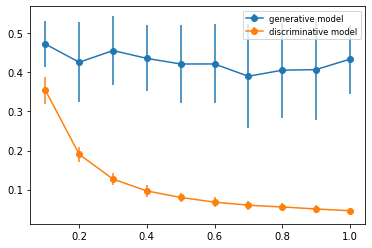

For data set B


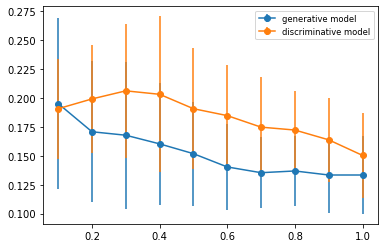

For data set usps


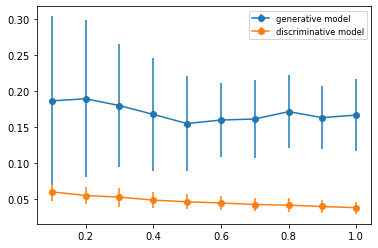

In [176]:
#calculating the mean and standard deviation of the error rate for different training size computed for 30 runs.
def mean_sd_calc(dict_data):
    fin_mat = np.array(np.zeros(10))
    fin_mat = np.expand_dims(fin_mat, axis=0)
    l = 0
    for i in dict_data.keys():
        itr = dict_data[i]
        temp = np.array(np.zeros(10))
        k = 0
        for j in itr.keys():
            temp[k] = itr[j]
            k += 1    
        temp = np.expand_dims(temp, axis=0)
        fin_mat = np.append(fin_mat,temp,axis=0)
        l += 1
    fin_mat = np.delete(fin_mat, (0), axis=0)
    mean = 0
    mean = np.mean(fin_mat,axis = 0)
    sd = np.std(fin_mat, axis=0)        
    return mean,sd

ma1,sa1 = mean_sd_calc(err_mat_A_gen)
ma2,sa2 = mean_sd_calc(err_mat_A_bay)
mb1,sb1 = mean_sd_calc(err_mat_B_gen)
mb2,sb2 = mean_sd_calc(err_mat_B_bay)
musps1,susps1 = mean_sd_calc(err_mat_usps_gen)
musps2,susps2 = mean_sd_calc(err_mat_usps_bay)
#plotting the results of mean and standard deviation for different training size for all the three models.
def plot_set(m1,m2,s1,s2):
    #fig, ax1 = plt.subplots()
    x1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    y1 = m1
    y2 = m2
    y3 = s1
    y4 = s2
    plt.errorbar(x1,y1,yerr=y3,label="generative model",marker='o')
    plt.errorbar(x1,y2,yerr=y4,label="discriminative model",marker='o')
    plt.legend(loc = 1,fontsize = 'small')
    plt.show()

print("For data set A")
plot_set(ma1,ma2,sa1,sa2)
print("For data set B")
plot_set(mb1,mb2,sb1,sb2)
print("For data set usps")
plot_set(musps1,musps2,susps1,susps2)

In [177]:
import time
#compute w using newton method
def wmap_det2(data,label):
    data = np.insert(data,0,1,axis = 1)
    wn_mat = {}
    d_t = data.transpose()
    wn = np.zeros(len(d_t))
    iden = np.identity(len(d_t))
    a_id = np.dot(alpha,iden)
    wn1 = wn
    n=0
    wn1 = np.expand_dims(wn1, axis=1)
    wn = np.expand_dims(wn, axis=1)
    while (True):
        num = np.linalg.norm((wn1-wn),ord = 2)
        den = np.linalg.norm(wn,ord=2)
        chk = num/den
        if (((chk < (10**-3)) | n>=100)):
            break
        wn = wn1
        y = np.array(np.zeros(len(data)))
        yi_r = np.array(np.zeros(len(data)))
        n += 1
        for i in range (len(data)):
            ai = np.dot(data[i],wn)
            yi = 1/(1+(np.exp(-ai)))
            y[i] = yi
            yi_r[i] = yi*(1-yi)     
        r = np.diag(yi_r)
        wn1_1 = np.dot(d_t,r)
        wn1_1 = np.dot(wn1_1,data)
        wn1_1 = a_id+wn1_1
        wn1_1 = np.linalg.inv(wn1_1)
        y = np.expand_dims(y, axis=1)
        wn1_2 = y-label
        wn1_2 = np.dot(d_t,wn1_2)
        wn1_2_2 = np.dot(alpha,wn)
        wn1_2 = wn1_2+wn1_2_2
        wn1 = np.dot(wn1_1,wn1_2)
        wn1 = wn-wn1
        t = time.time()
        wn_mat[t] = wn1
    return(wn_mat)
#compute sn based on given data and weight
def bay_mod_trn2(trn_d,trn_l,wmap):
    y = np.array(np.zeros(len(trn_d)))
    trn_dt = trn_d.transpose()
    sn_2 = 0 
    iden = np.identity(len(trn_dt))
    sn_1 = np.dot(1/alpha,iden)
    for i in range (len(trn_d)):
        ai = np.dot(trn_d[i],wmap)
        yi = 1/(1+(np.exp(-ai)))
        y[i] = yi
        val_1 = yi*(1-yi)
        tr = trn_d[i].transpose()
        val_2 = np.dot(trn_d[i],tr)
        val = val_1*val_2
        sn_2 = sn_2 + val
    sn = sn_1+sn_2
    return (sn)
#calculate error rate of model on test data
def bay_mod2(tr_d,tr_l,te_d,te_l,wn):
    tr_d = np.insert(tr_d,0,1,axis = 1)
    te_d = np.insert(te_d,0,1,axis = 1)
    sn = bay_mod_trn2(tr_d,tr_l,wn)
    wn_t = wn.transpose()
    err = 0
    crt = 0
    for i in range(len(te_d)):
        mu_a = np.dot(te_d[i],wn)
        sigma_sq_a = np.dot(te_d[i],sn)
        te_tr = te_d[i].transpose()
        sigma_sq_a = np.dot(sigma_sq_a,te_tr)
        k_si_sq_a = ((1+((np.pi*sigma_sq_a)/8))**(-1/2))
        sigma = k_si_sq_a*mu_a
        pr_ci = 1/(1+(np.exp(-sigma)))
        if (pr_ci >= (1/2)):
            pred_l = 1
        else:
            pred_l = 0
        if pred_l == te_l[i]:
            crt = crt+1
        else:
            err = err+1
    er_rt = err/len(te_l)
    return er_rt
#compute weights using gradient method
def grad_ascent(tr_d,tr_l,eta):
    tr_d = np.insert(tr_d,0,1,axis = 1)
    wn_mat = {}
    alpha = 0.1
    d_t = tr_d.transpose()
    wn = np.zeros(len(d_t))
    wn1 = wn
    n=0
    wn1 = np.expand_dims(wn1, axis=1)
    wn = np.expand_dims(wn, axis=1)
    freq=0
    while (True):
        num = np.linalg.norm((wn1-wn),ord = 2)
        den = np.linalg.norm(wn,ord=2)
        chk = num/den
        if (((chk < (10**-3)) | n>=6000)):
            break
        wn = wn1
        y = np.array(np.zeros(len(tr_d)))
        n += 1
        freq += 1
        for i in range (len(tr_d)):
            ai = np.dot(tr_d[i],wn)
            yi = 1/(1+(np.exp(-ai)))
            y[i] = yi
        y = np.expand_dims(y, axis=1)
        wn1_2 = y-tr_l
        wn1_2 = np.dot(d_t,wn1_2)
        wn1_2_2 = np.dot(alpha,wn)
        wn1_2 = wn1_2+wn1_2_2
        wn1 = np.dot(eta,wn1_2)
        wn1 = wn-wn1
        if freq == 10:
            t = time.time()
            wn_mat[t] = wn1
            freq = 0
    return(wn_mat)
#calculate time diff between given initial time and executed time.
def time_diff(timed,init):
    time_diff_ar = np.array(np.zeros(0))
    for i in timed.keys():
        time_diff = i-init
        time_diff_ar = np.append(time_diff_ar,time_diff)
    return time_diff_ar
#computing the average of the time-diff(which is execution time)
def avg_time(w_n1,w_n2,w_n3,init1,init2,init3):
    w_new_m = np.array(np.zeros(len(w_n1)))
    w_new_m = np.expand_dims(w_new_m, axis=0)
    w_new1 = time_diff(w_n1,init1)
    w_new1 = np.expand_dims(w_new1, axis=0)
    w_new2 = time_diff(w_n2,init1)
    w_new2 = np.expand_dims(w_new2, axis=0)
    w_new3 = time_diff(w_n3,init1)
    w_new3 = np.expand_dims(w_new3, axis=0)
    w_new_m = np.append(w_new_m,w_new1,axis=0)
    w_new_m = np.append(w_new_m,w_new2,axis=0)
    w_new = np.append(w_new_m,w_new3,axis=0)
    w_new = np.delete(w_new, (0), axis=0)
    mean = np.mean(w_new,axis = 0)
    return mean
#computing the weights using gradient and newton method and calculating the mean time consumption
def main_fn_2(data2,label2):
    eta = 10**(-3)
    data2 = np.array(data2)
    label2 = np.array(label2)
    N = len(data2)
    tr = int((2/3)*len(data2))
    tst = N-tr
    tr_d = data2[0:tr,0:len(data2[1])]
    tr_l = label2[0:tr,0:len(label2[1])]
    ts_d = data2[tr+1:N,0:len(data2[1])]
    ts_l = label2[tr+1:N,0:len(label2[1])]
    init1 = time.time()
    w_new = wmap_det2(tr_d,tr_l)
    init2 = time.time()
    w_grd = grad_ascent(tr_d,tr_l,eta)
    init3 = time.time()
    w_new1 = wmap_det2(tr_d,tr_l)
    init4 = time.time()
    w_grd1 = grad_ascent(tr_d,tr_l,eta)
    init5 = time.time()
    w_new2 = wmap_det2(tr_d,tr_l)
    init6 = time.time()
    w_grd2 = grad_ascent(tr_d,tr_l,eta)
    mean1 = avg_time(w_new,w_new1,w_new2,init1,init3,init5)
    mean2 = avg_time(w_grd,w_grd1,w_grd2,init2,init4,init6)
    return(mean1,mean2,w_new,w_grd,tr_d,tr_l,ts_d,ts_l)
#computing the error rate for given weights and data.
def err_rt(w_n,w_g,tr_d,tr_l,ts_d,ts_l):
    k=0
    err_n = np.array(np.zeros(len(w_n)))
    err_g = np.array(np.zeros(len(w_g)))
    for i in w_n.keys():
        bay_er = bay_mod2(tr_d,tr_l,ts_d,ts_l,w_n[i])
        err_n[k] = bay_er
        k += 1
    l=0
    for j in w_g.keys():
        bay_er = bay_mod2(tr_d,tr_l,ts_d,ts_l,w_g[j])
        err_g[l] = bay_er
        l += 1
    return (err_n,err_g)

da_a = csv_dict["A"]
la_a = csv_dict["labels-A"]
da_usps = csv_dict["usps"]
la_usps = csv_dict["labels-usps"]
m1,m2,w_n1,w_g1,trd1,trl1,tsd1,tsl1 = main_fn_2(da_a,la_a)
m3,m4,w_n2,w_g2,trd2,trl2,tsd2,tsl2 = main_fn_2(da_usps,la_usps)
ern1,erg1 = err_rt(w_n1,w_g1,trd1,trl1,tsd1,tsl1)
ern2,erg2 = err_rt(w_n2,w_g2,trd2,trl2,tsd2,tsl2)

C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/245736023.py:17: RuntimeWarning: invalid value encountered in double_scalars
  chk = num/den
C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/245736023.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  chk = num/den
C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/245736023.py:103: RuntimeWarning: invalid value encountered in double_scalars
  chk = num/den
C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/245736023.py:103: RuntimeWarning: divide by zero encountered in double_scalars
  chk = num/den


For set A


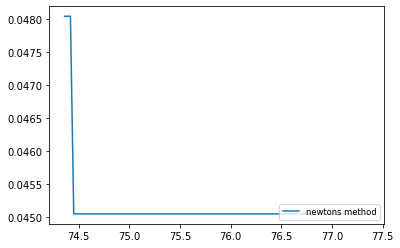

For set A


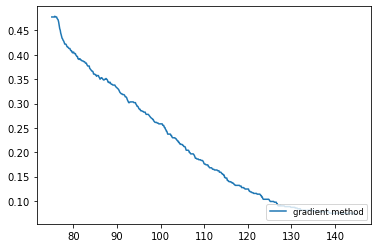

For set USPS


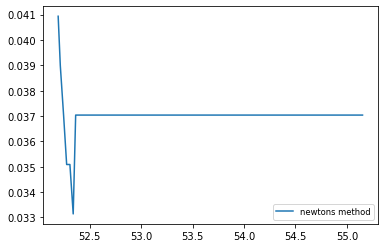

For set USPS


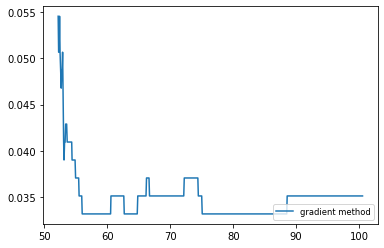

In [178]:
#plotting the time vs error rate computed above
x1 = m1
x2 = m2
y1 = ern1
y2 = erg1
print("For set A")
plt.plot(x1, y1,label = "newtons method")
plt.legend(loc = 4,fontsize = 'small')
plt.show()
print("For set A")
plt.plot(x2, y2,label = "gradient method")
plt.legend(loc = 4,fontsize = 'small')
plt.show()

x1 = m3
x2 = m4
y1 = ern2
y2 = erg2
print("For set USPS")
plt.plot(x1, y1,label = "newtons method")
plt.legend(loc = 4,fontsize = 'small')
plt.show()
print("For set USPS")
plt.plot(x2, y2,label = "gradient method")
plt.legend(loc = 4,fontsize = 'small')
plt.show()

In [ ]:
#line search
#dynamically determing the learning rate to reduce the number of computation and quickly reaching the final result of weights corresponding to MAP function
def grad(tr_d,tr_l,wn,eta):
    alpha = 0.1
    d_t = tr_d.transpose()    
    y = np.array(np.zeros(len(tr_d)))
    for i in range (len(tr_d)):
        ai = np.dot(tr_d[i],wn)
        yi = 1/(1+(np.exp(-ai)))
        y[i] = yi
    y = np.expand_dims(y, axis=1)
    wn1_2 = y-tr_l
    wn1_2 = np.dot(d_t,wn1_2)
    wn1_2_2 = np.dot(alpha,wn)
    grad = wn1_2+wn1_2_2
    wn1 = np.dot(eta,grad)
    return wn1
def bay_mod3(tr_d,tr_l,te_d,te_l,wn):
    sn = bay_mod_trn2(tr_d,tr_l,wn)
    wn_t = wn.transpose()
    err = 0
    crt = 0
    for i in range(len(te_d)):
        mu_a = np.dot(te_d[i],wn)
        sigma_sq_a = np.dot(te_d[i],sn)
        te_tr = te_d[i].transpose()
        sigma_sq_a = np.dot(sigma_sq_a,te_tr)
        k_si_sq_a = ((1+((np.pi*sigma_sq_a)/8))**(-1/2))
        sigma = k_si_sq_a*mu_a
        pr_ci = 1/(1+(np.exp(-sigma)))
        if (pr_ci >= (1/2)):
            pred_l = 1
        else:
            pred_l = 0
        if pred_l == te_l[i]:
            crt = crt+1
        else:
            err = err+1
    er_rt = err/len(te_l)
    return er_rt
def gradient_ascent_linesearch(tr_d,tr_l,te_d,te_l,eta):
    wn = np.zeros(len(tr_d[1]))
    wn1 = wn
    n=0
    wn1 = np.expand_dims(wn1, axis=1)
    wn = np.expand_dims(wn, axis=1)
    while (True):
        num = np.linalg.norm((wn1-wn),ord = 2)
        den = np.linalg.norm(wn,ord=2)
        chk = num/den
        if (((chk < (10**-7)) | n>=6000)):
            break
        er_wn = bay_mod3(tr_d,tr_l,te_d,te_l,wn)
        er_wn1 = bay_mod3(tr_d,tr_l,te_d,te_l,wn1)
        while (er_wn1>=er_wn):
            eta = eta/5
            wnew = grad(tr_d,tr_l,wn,eta)
            wn1 = wn-wnew
            er_wn = bay_mod3(tr_d,tr_l,te_d,te_l,wn)
            er_wn1 = bay_mod3(tr_d,tr_l,te_d,te_l,wn1)
        wn = wn1
        wnew = grad(tr_d,tr_l,wn,eta)
        wn1 = wn-wnew        
        n += 1
    er_rte = bay_mod3(tr_d,tr_l,te_d,te_l,wn1)
    return(wn1,er_rte,n)

def main_fn_3(data3,label3):
    data3 = np.array(data3)
    label3 = np.array(label3)
    N = len(data3)
    tr = int((2/3)*len(data3))
    tst = N-tr
    tr_d = data3[0:tr,0:len(data3[1])]
    tr_l = label3[0:tr,0:len(label3[1])]
    ts_d = data3[tr+1:N,0:len(data3[1])]
    ts_l = label3[tr+1:N,0:len(label3[1])]
    tr_d = np.insert(tr_d,0,1,axis = 1)
    ts_d = np.insert(ts_d,0,1,axis = 1)
    init = time.time()
    eta = 10**-2
    w_grd,er,steps = gradient_ascent_linesearch(tr_d,tr_l,ts_d,ts_l,eta)
    fin = time.time()
    print("time diff")
    print(init-fin)
    print("error rate of final weight")
    print(er)
    print("number of steps taken to determine the weight")
    print(steps)
da3_a = csv_dict["A"]
la3_a = csv_dict["labels-A"]
da3_usps = csv_dict["usps"]
la3_usps = csv_dict["labels-usps"]
main_fn_3(da3_a,la3_a)

C:\Users\DELL\AppData\Local\Temp/ipykernel_8028/2526486368.py:50: RuntimeWarning: invalid value encountered in double_scalars
  chk = num/den
